In [1]:
# common libraries
import pandas as pd
import numpy as np
import pickle
import re
import gc

# text preparation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pymorphy2
import nltk
import ssl

# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# data for model preparation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', text)
    text = re.sub("|[0-9]|[.,:;_%©«»?*!@#№$^•·&()=°'™-]|[\"]|[/]|", "", text) # +
    text = re.sub("[ΑαΒβΓγΔδΕεΖζΗηΘθΙιΚκΛλΜμµΝνΞξΟοΠπΡρΣσςΤτΥυΦφΧχΨψΩω]", "", text)
    text = re.sub("–-—", '-', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub(r'span', '', text)
    text = ' '.join([word for word in text.split(' ') if '\\' not in word and 'class' not in word])
    return text

def lemmatization(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    
    if not isinstance(text, str):
        text = str(text)
    words = list(word_tokenize(text))
    words_lem = []
    for w in words:
        if w[0] == '-':
            w = w[1:]
        if len(w)>1:
            if w in cache:
                words_lem.append(cache[w])
            else:
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    final_words =' '.join([i for i in words_lem if not i in stopwords.words('english')])
    final_words = nltk.word_tokenize(final_words)
    final_words = [wordnet_lemmatizer.lemmatize(word) for word in final_words]
    final_words = ' '.join(final_words)
    return final_words

# inverse hyperbolic sine transoformation
def ihs_transform(x, theta):
    return np.log(theta*x+np.sqrt(theta**2*x**2+1))/theta
    
morph = pymorphy2.MorphAnalyzer()
cache = {}

## Prepare train and test data

### Prepare database for model from _*.csv_
_*insert_database_name_

In [2]:
database = pd.read_csv('../../articles_databases/springer.csv')

Remove nans

In [3]:
database = database.drop(database[database['abstract'].isna() | database['journal'].isna()].index)

Get only 2000-2021 articles

In [4]:
database = database[database['publication_date']>'2000-01-01']
database = database[database['publication_date']<'2021-12-31']

In __Journal of Materials Research__ were incorrected dates of old articles (indexed as 2021th year).<br>
Remove journal or 2021 year articles from database.

In [5]:
remove_journal = False
if remove_journal:
    database = database.drop(database[database['journal'] == 'Journal of Materials Research'].index)
else:
    jomr = database[database['journal']=='Journal of Materials Research']
    jomr2011 = jomr[pd.DatetimeIndex(jomr['publication_date']).year == 2011]
    jomr2011_01 = jomr2011[pd.DatetimeIndex(jomr2011['publication_date']).month == 1]
    database = database.drop(jomr2011.index)

Get the information about number of articles in each journal

In [6]:
groups = database.groupby('journal')['abstract'].count()
print(groups.to_string())

journal
Acta Metallurgica Sinica (English Letters)                                      1462
Advanced Composites and Hybrid Materials                                         372
Advanced Fiber Materials                                                         106
Applied Composite Materials                                                     1100
Applied Nanoscience                                                             1700
Bulletin of Materials Science                                                   3335
Carbon Letters                                                                   312
Electronic Materials Letters                                                    1290
Experimental Techniques                                                          936
Frontiers of Materials Science                                                   739
Glass Physics and Chemistry                                                     2033
Glass and Ceramics                                       

Remove journals with the few nuber of articles.<br>
Also, if the number of articles is too much, get the sample ($n_{max} = n_{publications}*k)$.

In [7]:
n_publications = 2750
k = 1.25
n_max = int(n_publications*k)

for journal, n in zip(list(groups.keys()), groups.values):
    if n<n_publications:
        database = database.drop(database[database['journal'] == journal].index)
    elif n>n_max:
        database[database['journal']==journal] = database[database['journal']==journal].sample(n=n_max)
    else:
        pass

In [8]:
journals = database.groupby('journal')['abstract'].count()
journals

journal
Bulletin of Materials Science                                                  3335
Journal of Electronic Materials                                                3437
Journal of Materials Engineering and Performance                               3437
Journal of Materials Research                                                  3437
Journal of Materials Science                                                   3437
Journal of Materials Science: Materials in Electronics                         3437
Journal of Materials Science: Materials in Medicine                            3437
Journal of Nanoparticle Research                                               3437
Journal of Sol-Gel Science and Technology                                      3437
Journal of Surface Investigation: X-ray, Synchrotron and Neutron Techniques    3142
Journal of Wuhan University of Technology-Mater. Sci. Ed.                      3437
Metallurgical and Materials Transactions A                          

Remove irrelevant journals

In [13]:
irrelevant_journals = ['Journal of Materials Science: Materials in Electronics',
                        'Journal of Materials Science',
                        'Journal of Materials Research',
                        'Metals and Materials International']
#irrelevant_journals = []

In [14]:
for journal in irrelevant_journals:
    database = database.drop(database[database['journal'] == journal].index)
journals = database.groupby('journal')['abstract'].count()

Histograms of publications per year

In [15]:
plot_publication_date = False
if plot_publication_date:
    for journal in list(journals.keys()):
        data = database[database['journal']==journal]
        hist_data = data['publication_date'].astype('datetime64')
        (hist_data.groupby(hist_data.dt.year).count()).plot(kind='bar')
        plt.title(journal)
        plt.show()

In [16]:
database['journal_index'] = None

Index each journal for classification task

In [17]:
for i, journal in enumerate(list(journals.keys()), 0):
    print(i, journal)
    mask = database['journal'] == journal
    database.loc[mask, 'journal_index']=i

0 Bulletin of Materials Science
1 Journal of Electronic Materials
2 Journal of Materials Engineering and Performance
3 Journal of Materials Science: Materials in Medicine
4 Journal of Nanoparticle Research
5 Journal of Sol-Gel Science and Technology
6 Journal of Surface Investigation: X-ray, Synchrotron and Neutron Techniques
7 Journal of Wuhan University of Technology-Mater. Sci. Ed.
8 Metallurgical and Materials Transactions A
9 Metallurgical and Materials Transactions B
10 Nano Research
11 Protection of Metals and Physical Chemistry of Surfaces
12 Tribology Letters


Cleaning and Lemmatization

In [18]:
%%time
database['abstract'] = database['abstract'].apply(lambda x: clean_text(x), 1)

CPU times: user 15.5 s, sys: 179 ms, total: 15.7 s
Wall time: 17.5 s


In [21]:
%%time
database['abstract'] = database['abstract'].apply(lambda x: lemmatization(x), 1)

CPU times: user 11min 28s, sys: 2min 43s, total: 14min 11s
Wall time: 14min 52s


Finally, remove last nans, check and save database and journals titles files

In [22]:
database = database.drop(database[database['abstract'].isna() | database['journal'].isna()].index)

In [23]:
database[database.isnull().any(axis=1)]

,journal,url,doi,publication_date,title,abstract,journal_index


In [24]:
with open('../support_files/journals_labels.txt', 'w') as f:
    for label in list(journals.keys()):
        f.write("%s\n"%(label))

In [25]:
database.to_pickle('../data/springer_learning_database.pkl')

In [26]:
del database

### Data preparation

Load database and split the data

In [2]:
df = pd.read_pickle('../data/springer_learning_database.pkl')        

In [3]:
X, y = df['abstract'], df['journal']

In [4]:
del df
gc.collect();

#### TF-IDF preprocessing

In [5]:
tfidf = TfidfVectorizer(lowercase=False)

In [6]:
X = tfidf.fit_transform(X)

In [7]:
pickle.dump(tfidf, open('../support_files/tfidf.vectorizer', 'wb'))

To find some rarely used words and improve model quality we can convert the vectorized dataframe to pandas dataframe. <br>
To reduce memory usage datatype can be `float16`

In [8]:
X = pd.DataFrame(np.array(X.toarray(), dtype=np.float16), columns = tfidf.get_feature_names_out())

In [9]:
print(f'Database takes {int(X.memory_usage().sum()/1024**2)} MB')

Database takes 8124 MB


Let's find find rarely used words in the train sample:

0. For example low limit for words number will be n%
1. Mask the tfidf values by 0 or 1
2. Find sum of each word in column
3. Remove the rarely used words (< n%) from the train sample

In [11]:
rarely_used_words = 0.03

In [12]:
%%time
X = X.loc[:, X.mask(X>0.0, 1.0).sum().values>int(X.shape[0]*rarely_used_words)]

CPU times: user 4min 48s, sys: 1min 9s, total: 5min 57s
Wall time: 6min 31s


Remove the __pct__ and __wt__ (%) columns <br>
_P.S. artifact was found during first model training_

In [15]:
X = X.drop(columns=['pct', 'wt'])

Save the vectorized X dataframe and tfidf used words

In [17]:
X.to_pickle('../data/X_v.pkl')  

In [18]:
with open('../support_files/tfidf_words.txt', 'w') as f:
    for label in list(X.keys()):
        f.write("%s\n"%(label))

### Scaling and transormation

In [2]:
X = pd.read_pickle("../data/X_v.pkl")

Make the _inverse hyperbolic sine_ transforamtion. <br> 
Information can be found elsewhere 
[[1](https://academic.oup.com/ectj/article/24/2/334/5948096), 
[2](https://stats.stackexchange.com/a/1630)]

Find optimal hyperparameters

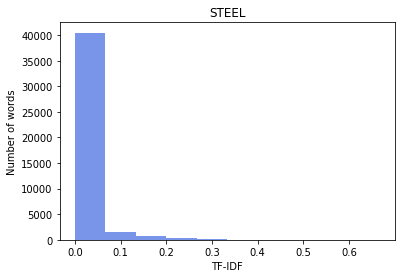

In [9]:
plt.hist(X['steel'], color = 'royalblue', alpha = 0.7)
plt.ylabel('Number of words')
plt.xlabel('TF-IDF')
plt.title('STEEL');

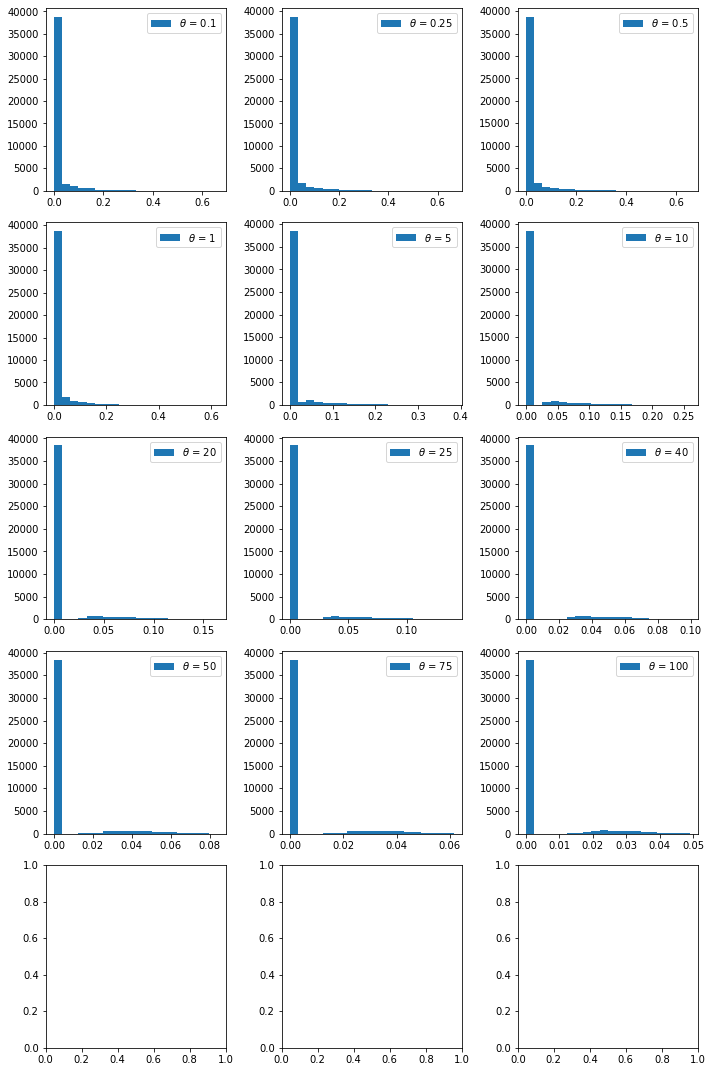

In [20]:
ihr_thetas = [0.1, 0.25, 0.5, 1, 5, 10, 20, 25, 40, 50, 75, 100]

fig, ax = plt.subplots(len(ihr_thetas)//3+1, 3, figsize=(10, 3*(len(ihr_thetas)//3+1)))
for ax, theta in zip(ax.flatten(), ihr_thetas):
    dat = ihs_transform(X['steel'], theta=theta)
    ax.hist(dat, label=fr'$\theta$ = {theta}', bins=20)
    ax.legend()
    
fig.tight_layout()
plt.show()

In [10]:
theta = 40

In [11]:
X = ihs_transform(X, theta=theta)

Add new feature - number of words in abstract

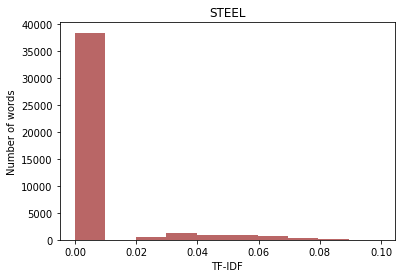

In [15]:
plt.hist(X['steel'], color = 'darkred', alpha = 0.6)
plt.ylabel('Number of words')
plt.xlabel('TF-IDF')
plt.title('STEEL');

In [16]:
X['words_in_abstract'] = X.mask(X>0.0, 1.0).sum(axis=1)

In [40]:
#X = X.drop(list(X[X['words_in_abstract']==X['words_in_abstract'].min()].index), axis=0)

In [47]:
scaler = MinMaxScaler()

In [48]:
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)

Save the prepared train and test data

In [50]:
X.to_pickle('../data/X.pkl'), y.to_pickle('../data/y.pkl');

## Classification models

In [88]:
y_train, y_test = pd.read_pickle("../data/y_train.pkl"), pd.read_pickle("../data/y_test.pkl")
X_train, X_test = pd.read_pickle("../data/X_train.pkl"), pd.read_pickle("../data/X_test.pkl")

### LightGBM

In [89]:
lgbm_model = LGBMClassifier(random_state=122, reg_alpha=0.25, reg_lambda=0.1)

NameError: name 'LGBMClassifier' is not defined

In [134]:
lgbm_model.fit(X_train, list(y_train), 
               eval_metric='multi_logloss', 
               eval_set=[(X_test, y_test)])

[1]	valid_0's multi_logloss: 2.58711
[2]	valid_0's multi_logloss: 2.46184
[3]	valid_0's multi_logloss: 2.36928
[4]	valid_0's multi_logloss: 2.29887
[5]	valid_0's multi_logloss: 2.23889
[6]	valid_0's multi_logloss: 2.18958
[7]	valid_0's multi_logloss: 2.14701
[8]	valid_0's multi_logloss: 2.10965
[9]	valid_0's multi_logloss: 2.07652
[10]	valid_0's multi_logloss: 2.04596
[11]	valid_0's multi_logloss: 2.01881
[12]	valid_0's multi_logloss: 1.99433
[13]	valid_0's multi_logloss: 1.97203
[14]	valid_0's multi_logloss: 1.95054
[15]	valid_0's multi_logloss: 1.93109
[16]	valid_0's multi_logloss: 1.91359
[17]	valid_0's multi_logloss: 1.89699
[18]	valid_0's multi_logloss: 1.88088
[19]	valid_0's multi_logloss: 1.8651
[20]	valid_0's multi_logloss: 1.85148
[21]	valid_0's multi_logloss: 1.83958
[22]	valid_0's multi_logloss: 1.82738
[23]	valid_0's multi_logloss: 1.81657
[24]	valid_0's multi_logloss: 1.80502
[25]	valid_0's multi_logloss: 1.79502
[26]	valid_0's multi_logloss: 1.785
[27]	valid_0's multi_log

LGBMClassifier(random_state=122, reg_alpha=0.25, reg_lambda=0.1)

In [135]:
show_classification_report(list(y_train), lgbm_model.predict(X_train), 
                           title='TRAIN (LightGBM)', labels=labels)
show_classification_report(list(y_test), lgbm_model.predict(X_test), 
                           title='TEST (LightGBM)', labels=labels)

TRAIN (LightGBM)
                                                                           precision    recall  f1-score   support

                                            Bulletin of Materials Science       0.87      0.74      0.80      2484
                                          Journal of Electronic Materials       0.81      0.81      0.81      2618
                         Journal of Materials Engineering and Performance       0.85      0.82      0.83      2575
                                            Journal of Materials Research       0.86      0.67      0.76      2579
                                             Journal of Materials Science       0.90      0.58      0.70      2518
                   Journal of Materials Science: Materials in Electronics       0.82      0.82      0.82      2588
                      Journal of Materials Science: Materials in Medicine       0.83      0.91      0.87      2540
                                         Journal of Nanopartic

#### Save the model

In [136]:
pickle.dump(lgbm_model, open('lgbm.model', 'wb'))

### LightGBM CrossValidation and ParametersSearch

In [129]:
X_train_v = X_dataset.head(X_train_v.shape[0])
X_test_v = X_dataset.tail(X_dataset.shape[0]-X_train_v.shape[0])

In [144]:
lgbm_model = LGBMClassifier(random_state=122)

In [145]:
params = {'num_leaves': [10, 25, 50, 100],
          'learning_rate': [0.1, 0.25, 0.5],
          'n_estimators':[10, 50, 100],
          'max_depth':[5, 10, 25], 
          'reg_alpha': [0, 0.1, 0.25, 0.5, 2, 5],
          'reg_lambda': [0, 0.1, 0.25, 0.5, 2, 5]}

In [146]:
cv=KFold(n_splits=5, 
         random_state=122, 
         shuffle=True)

In [147]:
rs = RandomizedSearchCV(lgbm_model, 
                        params, 
                        scoring='recall_macro', 
                        cv=cv, n_jobs=-1, 
                        error_score='raise', 
                        verbose = -1)

In [148]:
rs.fit(X_train, list(y_train),
       eval_metric='multi_logloss', 
       eval_set=[(X_test, y_test)])

[1]	valid_0's multi_logloss: 2.26784
[2]	valid_0's multi_logloss: 2.11096
[3]	valid_0's multi_logloss: 1.99749
[4]	valid_0's multi_logloss: 1.9094
[5]	valid_0's multi_logloss: 1.83772
[6]	valid_0's multi_logloss: 1.77606
[7]	valid_0's multi_logloss: 1.7231
[8]	valid_0's multi_logloss: 1.6776
[9]	valid_0's multi_logloss: 1.63733
[10]	valid_0's multi_logloss: 1.60269
[11]	valid_0's multi_logloss: 1.56915
[12]	valid_0's multi_logloss: 1.53919
[13]	valid_0's multi_logloss: 1.51323
[14]	valid_0's multi_logloss: 1.48971
[15]	valid_0's multi_logloss: 1.46695
[16]	valid_0's multi_logloss: 1.44805
[17]	valid_0's multi_logloss: 1.42861
[18]	valid_0's multi_logloss: 1.41046
[19]	valid_0's multi_logloss: 1.39303
[20]	valid_0's multi_logloss: 1.37862
[21]	valid_0's multi_logloss: 1.36474
[22]	valid_0's multi_logloss: 1.35203
[23]	valid_0's multi_logloss: 1.33993
[24]	valid_0's multi_logloss: 1.32824
[25]	valid_0's multi_logloss: 1.31767
[26]	valid_0's multi_logloss: 1.30712
[27]	valid_0's multi_log

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=122, shuffle=True),
                   error_score='raise',
                   estimator=LGBMClassifier(random_state=122), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.25, 0.5],
                                        'max_depth': [5, 10, 25],
                                        'n_estimators': [10, 50, 100],
                                        'num_leaves': [10, 25, 50, 100],
                                        'reg_alpha': [0, 0.1, 0.25, 0.5, 2, 5],
                                        'reg_lambda': [0, 0.1, 0.25, 0.5, 2,
                                                       5]},
                   scoring='recall_macro', verbose=-1)

In [150]:
rs.best_params_

{'reg_lambda': 0.1,
 'reg_alpha': 2,
 'num_leaves': 100,
 'n_estimators': 50,
 'max_depth': 25,
 'learning_rate': 0.1}

### Use the best parameters for final model

In [151]:
rs_lgbm = LGBMClassifier(random=122, **rs.best_params_, verbose = -1)

In [152]:
rs_lgbm.fit(X_train, list(y_train), eval_metric='multi_logloss')

LGBMClassifier(max_depth=25, n_estimators=50, num_leaves=100, random=122,
               reg_alpha=2, reg_lambda=0.1, verbose=-1)

In [153]:
show_classification_report(list(y_train), rs_lgbm.predict(X_train), 
                           title='TRAIN (LightGBM)', labels=labels)
show_classification_report(list(y_test), rs_lgbm.predict(X_test), 
                           title='TEST (LightGBM)', labels=labels)

TRAIN (LightGBM)
                                                                           precision    recall  f1-score   support

                                            Bulletin of Materials Science       0.92      0.86      0.89      2520
                                          Journal of Electronic Materials       0.92      0.89      0.90      2594
                         Journal of Materials Engineering and Performance       0.92      0.90      0.91      2597
                      Journal of Materials Science: Materials in Medicine       0.92      0.93      0.93      2578
                                         Journal of Nanoparticle Research       0.91      0.92      0.91      2589
                                Journal of Sol-Gel Science and Technology       0.93      0.96      0.95      2566
Journal of Surface Investigation: X-ray, Synchrotron and Neutron Techniqu       0.92      0.96      0.94      2331
                Journal of Wuhan University of Technology-Mate

#### Save the model

In [155]:
pickle.dump(rs_lgbm, open('lgbm_classifier.model', 'wb'))

## Let's check the model on some thesis

In [3]:
prediction_tfidf = pickle.load(open('tfidf.model', 'rb'))

In [8]:
labels = []
with open('journal_labels.txt', 'r') as f:
    for line in f:
        labels.append(line[:-1])
labels = [l[:73] for l in labels]

In [4]:
tfidf_words = []
with open('tfidf_words.txt', 'r') as f:
    for line in f:
        tfidf_words.append(line[:-1])

In [5]:
prediction_model = pickle.load(open('lgbm_classifier.model', 'rb'))

In [6]:
springer_journals = pd.read_csv('../scrapers/springer/journals_database.csv')

#### Coating abstract

In [9]:
abstract = 'The Fe66Cr10Nb5B19 alloy coatings with high hardness (~850 HV300), low porosity (less 3%), low content of crystalline phase (less 2.5 wt.%), elevated nanohardness (average value 13.7 GPa), and high wear resistance were obtained in a wide range of detonation spraying modes. The results under dry linearly reciprocating sliding wear tests of coatings and stainless steel carried out according to ASTM G 133-05 are presented. The volume loss of detonation coatings obtained at an explosive charge of 50–70%, measured on an optical profilometer, is significantly lower than that of stainless steel. The similar values of volume scratches of Fe66Cr10Nb5B19 coatings obtained at an explosive charge of 40–70% can be attributed to similar values of porosity and content of crystalline phase. The scratch and spalling mechanisms are the main mechanisms of material removal from the coatings.'
abstract_journal_prediction(abstract, 
                            model=prediction_model, 
                            tfidf=prediction_tfidf,
                            tfidf_words=tfidf_words)

,probability,journal,impact_factor
1,49.16,Tribology Letters,3.327
2,15.35,Metallurgical and Materials Transactions A,2.726
3,12.60,Journal of Materials Engineering and Performance,2.036
4,5.07,Protection of Metals and Physical Chemistry of...,0.943
5,4.34,Journal of Wuhan University of Technology-Mate...,1.271
6,3.30,Journal of Materials Science: Materials in Med...,4.727
7,2.91,Bulletin of Materials Science,1.878
8,2.32,Journal of Sol-Gel Science and Technology,2.606
9,1.87,Metallurgical and Materials Transactions B,2.872
10,1.20,Journal of Electronic Materials,2.047


#### Friction abstract

In [10]:
abstract = 'A materials’ structure and its evolution due to friction play a crucial role in understanding wear and related processes. So far, structural changes caused by friction are mostly studied using ex situ destructive characterization techniques, such as microscopy of post-mortem the prepared specimen by polishing and etching techniques. In this paper, the structural changes of AISI 321 austenitic stainless steel (ASS) during frictional loading were observed by the nondestructive operando method based on synchrotron X-ray diffraction (XRD). Although the martensitic transformation in AISI 321 steel starts at ca. -187 ∘ C, frictional loading induces γ-(ε, α′) transformation in this alloy at room or even higher temperatures. The ε-martensite formation is observed only for a relatively short time. Subsequently, a mechanically mixed layer (MML), composed mainly of the α′ phase, forms at the sample’s surface. Using XRD peak profile analysis, we observed the accumulation of dislocations, their ordering, and/or stress field shielding before and after phase transformations. The steady-state conditions are reached after ca. 69 friction cycles manifested in reaching the threshold values of the size of the coherent scattering regions (CSR) and dislocation density in γ and α′ phases. For a better understanding of structural evolution, the microstructure of the sample was studied by scanning electron microscopy (SEM) after the experiment. The structure of the MML, its delamination, the formation of vortices, and carbide crushing are discussed.'
abstract_journal_prediction(abstract, 
                            model=prediction_model, 
                            tfidf=prediction_tfidf,
                            tfidf_words=tfidf_words)

,probability,journal,impact_factor
1,36.34,Tribology Letters,3.327
2,31.27,Metallurgical and Materials Transactions A,2.726
3,11.45,Journal of Materials Engineering and Performance,2.036
4,5.30,Bulletin of Materials Science,1.878
5,4.40,Journal of Materials Science: Materials in Med...,4.727
6,3.42,Journal of Wuhan University of Technology-Mate...,1.271
7,2.94,Metallurgical and Materials Transactions B,2.872
8,1.94,Journal of Electronic Materials,2.047
9,1.10,Journal of Nanoparticle Research,2.533
10,0.59,Nano Research,10.269


#### HEA Profile Analysis

In [193]:
abstract = 'In this study, we compare several peak profile analysis methods for the investigation of the CoCrFeMnNi high-entropy alloy (HEA) after the plastic deformation. We show that conventional Williamson - Hall (cWH) approach poorly correlates with measured peak broadening and some corrections must be introduced to improve the analysis. The correction for elastic modulus for different crystallographic directions or application of modified Williamson Hall (mWH) and modified Warren - Averbach (mWA) methods significantly improve the correlation between the model and experimental data. Peak profile analysis shows that the dislocation density of the CoCrFeMnNi alloy subjected to axial compression increases with increase in strain and reaches plateau at a strain of 47.5%. At the same time, the crystallite size decreases, and dislocation structure becomes more disordered.'
abstract_journal_prediction(abstract, 
                            model=prediction_model, 
                            tfidf=prediction_tfidf,
                            tfidf_words=tfidf_words)

,probability,journal,impact_factor
1,45.60,Metallurgical and Materials Transactions A,2.726
2,10.50,Journal of Materials Engineering and Performance,2.036
3,8.58,Metallurgical and Materials Transactions B,2.872
4,7.11,Journal of Materials Science: Materials in Med...,4.727
5,6.50,Journal of Nanoparticle Research,2.533
6,5.59,Bulletin of Materials Science,1.878
7,5.48,Journal of Electronic Materials,2.047
8,3.18,Nano Research,10.269
9,3.13,Journal of Wuhan University of Technology-Mate...,1.271
10,1.46,"Journal of Surface Investigation: X-ray, Synch...",0.359


#### Intermetallic laminates

In [195]:
abstract = 'Ti-Al3Ti metal-intermetallic laminate (MIL) composites are known as promising structural materials due to the unique combination of their specific properties. However, their application is still limited due to the extremely high brittleness of the Al3Ti phase. In this study, we attempt to address this issue by changing the D022 crystal structure of Al3Ti to the more ductile L12 structure by alloying it with silver. To select the best fabrication regimes of Ti-Ti(Al1-xAgx)3 composites, in situ synchrotron X-ray diffraction analysis was performed to reveal the chemical reactions occurring upon heating the Ti-Al-Ag sample. The analysis showed that the highest amount of Ti(Al1-xAgx)3 phase with the L12 structure appears at 930 °C. This temperature was chosen for subsequent spark plasma sintering experiments. Scanning electron microscopy, energy dispersive X-ray analysis, and X-ray diffraction analysis revealed that the sintered sample consisted mainly of Ti, Ti(Al1-xAgx)3, and a minor fraction of the Ag-Al compound distributed in the central parts of the intermetallic layers and at the grain boundaries. Modification of the titanium trialuminide crystal structure positively affected the properties of the composite, providing a 60% increase in fracture toughness. The Ag-Al phase also contributed to toughening, causing an additional crack deflection effect.'
abstract_journal_prediction(abstract, 
                            model=prediction_model, 
                            tfidf=prediction_tfidf,
                            tfidf_words=tfidf_words)

,probability,journal,impact_factor
1,47.82,Journal of Materials Science: Materials in Med...,4.727
2,11.85,Metallurgical and Materials Transactions B,2.872
3,10.23,Bulletin of Materials Science,1.878
4,6.72,Journal of Electronic Materials,2.047
5,6.19,Journal of Wuhan University of Technology-Mate...,1.271
6,5.03,Metallurgical and Materials Transactions A,2.726
7,4.19,Journal of Nanoparticle Research,2.533
8,2.30,Journal of Materials Engineering and Performance,2.036
9,1.92,Nano Research,10.269
10,1.41,"Journal of Surface Investigation: X-ray, Synch...",0.359


### catboost

In [57]:
catboost_model = CatBoostClassifier(random_seed=122, 
                                    custom_loss=['Recall'],
                                    loss_function='MultiClass',
                                    task_type='CPU', 
                                    verbose=False)

In [58]:
catboost_model.fit(X_train_v, y_train, 
                   eval_set=[(X_test_v, y_test)], 
                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [60]:
show_classification_report(list(y_train), catboost_model.predict(X_train_v), 
                           title='TRAIN (catboost)', labels=labels)
show_classification_report(list(y_test), catboost_model.predict(X_test_v), 
                           title='TEST (catboost)', labels=labels)

TRAIN (catboost)
                                                                           precision    recall  f1-score   support

                                            Bulletin of Materials Science       0.71      0.60      0.65      2520
                                          Journal of Electronic Materials       0.70      0.67      0.69      2594
                         Journal of Materials Engineering and Performance       0.69      0.62      0.65      2597
                      Journal of Materials Science: Materials in Medicine       0.74      0.78      0.76      2578
                                         Journal of Nanoparticle Research       0.67      0.69      0.68      2589
                                Journal of Sol-Gel Science and Technology       0.82      0.77      0.80      2566
Journal of Surface Investigation: X-ray, Synchrotron and Neutron Techniqu       0.77      0.87      0.82      2331
                Journal of Wuhan University of Technology-Mate

In [91]:
feature_importances = pd.DataFrame({'feature': catboost_model.feature_names_, 
                                    'importance': catboost_model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

In [92]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feature_importances)

               feature  importance
165           friction    2.985231
357                sol    2.744688
255      nanoparticles    2.627012
445  words_in_abstract    2.481839
369              steel    2.350848
259                 nm    1.825588
12               alloy    1.687435
85           corrosion    1.616275
435               wear    1.349573
290           prepared    1.324397
377            studied    1.168943
328            results    1.106697
36            behavior    1.021230
171                gel    0.983735
383            surface    0.981979
340              shown    0.978137
13              alloys    0.947395
432              vitro    0.941416
246     microstructure    0.912631
371           strength    0.862807
442               xray    0.855090
46               cells    0.813075
23        applications    0.802094
276        performance    0.801531
361               span    0.766341
128           electron    0.749891
379              study    0.736282
174              gra

In [ ]:
plot_multilabel_confusion_matrix(y_test, y_pred, labels=labels)

In [61]:
pickle.dump(catboost_model, open('catboost.model', 'wb'))

In [204]:
xgb_model = XGBClassifier(random_state=122)

In [205]:
xgb_model.fit(X_train_v, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=122, reg_alpha=0, ...)

In [208]:
y_pred = xgb_model.predict(X_test_v)

In [209]:
labels = [el[:73] for el in list(journals.keys())]
print(classification_report(list(y_test), y_pred, 
                            target_names=labels))

                                                                           precision    recall  f1-score   support

                                            Bulletin of Materials Science       0.52      0.48      0.50       846
                                          Journal of Electronic Materials       0.58      0.62      0.60       961
                         Journal of Materials Engineering and Performance       0.37      0.42      0.39       932
                                            Journal of Materials Research       0.35      0.32      0.33       945
                   Journal of Materials Science: Materials in Electronics       0.30      0.22      0.25       965
                      Journal of Materials Science: Materials in Medicine       0.77      0.81      0.79       912
                                         Journal of Nanoparticle Research       0.53      0.63      0.57       899
                                Journal of Sol-Gel Science and Technology      

In [16]:
#parameters = {'learning_rate': [0.05, 0.1, 0.25, 0.5],
#              'max_depth': [3, 5, 10, 20, 50],
#              'n_estimators': [5, 10, 100, 1000]}

#gs = GridSearchCV(model, parameters, n_jobs=5, 
#                   cv=5, 
#                   scoring='recall')
#gs.fit(X_train_v, y_train)
#gs.best_params_
#model = gs.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1920, in recall_score
 


KeyboardInterrupt

